# Introduction to Astropy: V. Quantities 

## Table of Content


V. [Use of "Quantities" for astrophysical calculation](#V.-Use-of-"Quantities"-for-astrophysical-calculation)

XX. [References](#XX-References)


In [1]:
# As usual, we start with some imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## V. Use of "Quantities" for astrophysical calculation

Astropy's `Quantity` object can make astrophysics calculations easier. The example include calculating the mass of a galaxy from its velocity dispersion.  

Using `Quantity` object could also be a good practice for using quantities in functions you distribute to other people. This may avoid people assuming different units and making big mistakes !

As we have seen above, attaching units to variable is done using `astropy.units`. It is conventional to import it as `u`, so your import should look like `import astropy.units as u`. 

Astropy also has a `constants` module, where typical physical constants are available.  The constants are stored as objects of a subclass of `Quantity`, so they behave just like a `Quantity`. Here, we'll only need the gravitational constant `G`, Planck's constant `h`, and Boltzmann's constant, `k_B`.

In [2]:
import astropy.units as u
from astropy.constants import G, h, k_B

In this example, we will use `Quantity` objects to estimate a hypothetical galaxy's mass, given its half-light radius and radial velocities of stars in the galaxy.

Lets assume that we measured the half light radius of the galaxy  to be 29 pc projected on the sky at the distance of the galaxy.  This radius is often called the "effective radius", so we will store it as a `Quantity` object with the name `Reff`. The easiest way to create a `Quantity` object is just by multiplying the value with its unit. Units are accessed as u."unit", in this case u.pc.

In [3]:
Reff = 29 * u.pc

A completely equivalent (but more verbose) way of doing the same thing is to use the `Quantity` object's initializer, demonstrated below.  In general, the simpler form (above) is preferred, as it is closer to how such a quantity would actually be written in text.  The initalizer form has more options, though, which you can learn about from the [astropy reference documentation on Quantity](http://docs.astropy.org/en/stable/api/astropy.units.quantity.Quantity.html).

In [4]:
Reff = u.Quantity(29, unit=u.pc)

We can access the value and unit of a `Quantity` using the `value` and `unit` attributes.

In [5]:
print('Half light radius %.2f %s' %(Reff.value, Reff.unit))

Half light radius 29.00 pc


Next, we will first create a synthetic dataset of radial velocity measurements, assuming a normal distribution with a mean velocity of 206 km/s and a velocity dispersion of 4.6 km/s.

In [6]:
vmean = 206
sigin = 4.6
v = np.random.normal(vmean, sigin, 500)*u.km/u.s
# For the illustration we convert to m/s
print('First 10 radial velocity measurements :' )
print(['%.2f %s ' %(v.to(u.m/u.s)[i].value, v.to(u.m/u.s)[i].unit) for i in range(10)])


First 10 radial velocity measurements :
['208693.82 m / s ', '213593.72 m / s ', '201026.30 m / s ', '201519.61 m / s ', '199066.64 m / s ', '211167.36 m / s ', '195659.09 m / s ', '213771.71 m / s ', '206072.29 m / s ', '200603.68 m / s ']


Note that created this way, `v` is not an `numpy.array` object but an `atropy.units.quantity.Quantity` object as we'll see below: 

In [7]:
print('type(v) =', type(v))
v_unitless = np.random.normal(vmean, sigin, 500)
print('type(v_unitless) = ', type(v_unitless))

type(v) = <class 'astropy.units.quantity.Quantity'>
type(v_unitless) =  <class 'numpy.ndarray'>


Plotting `Quantity` objects generally does not work straight away ... You might need to take the `value` of your quantity in the desired units to display it.  

Text(0, 0.5, 'N')

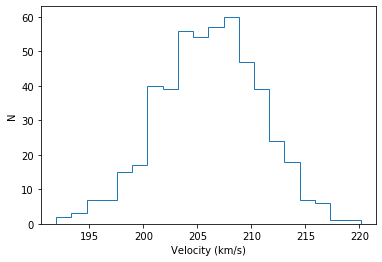

In [8]:
plt.figure()
plt.hist(v.value, bins=20, histtype="step")   
plt.xlabel("Velocity (km/s)")
plt.ylabel("N")

Next, we calculate the velocity dispersion of the galaxy.  This demonstrates how you can perform basic operations like subtraction and division with `Quantity` objects, and also use them in standard numpy functions such as `mean()` and `size()`. They retain their units through these operations just as you would expect them to.

In [9]:
sigma = np.sqrt(np.sum((v - np.mean(v))**2) / np.size(v))
print('Velocity dispersion: %.2f %s' %(sigma.value, sigma.unit))

Velocity dispersion: 4.68 km / s


**Note**: In general, you should only use `numpy` functions with `Quantity` objects, *not* the `math` equivalents, unless you are sure you understand the consequences.

Now for the actual mass calculation.  If a galaxy is pressure-supported (for example, an elliptical or dwarf spheroidal galaxy), its mass within the stellar extent can be estimated using a straightforward formula: 

$$
M_{1/2}=\frac{4\sigma^2 R_{eff}}{G}.
$$  

There are caveats to the use of this formula for science - see Wolf et al. 2010 for details.  For demonstrating `Quantity`, just accept that this is often good enough. For the calculation we can just multiply the quantities together, and `astropy` will keep track of the units.

In [10]:
M = 4*sigma**2*Reff/G
M

<Quantity 3.81448614e+13 kg km2 pc / m3>

The result is in a composite unit, so it's not really obvious it's a mass. However, it can be decomposed to cancel all of the length units ($\rm{km}^2 \rm{pc}/\rm{m}^3$) using the `decompose()` method.

In [11]:
M.decompose()

<Quantity 1.17702744e+36 kg>

We can also easily express the mass in whatever form you like - solar masses are common in astronomy, or maybe you want the default SI and CGS units.

In [12]:
print('Galaxy mass' )
print('in solar units: %.3e %s' %(M.to(u.Msun).value, M.to(u.Msun).unit) )
print('SI units: %.3e %s' %(M.si.value, M.si.unit) )
print('CGS units: %.3e %s' %(M.cgs.value, M.cgs.unit) )

Galaxy mass
in solar units: 5.919e+05 solMass
SI units: 1.177e+36 kg
CGS units: 1.177e+39 g


Or, if you want the log of the mass, you can just use ``np.log10`` as long as the logarithm's argument is dimensionless.

In [13]:
np.log10(M / u.Msun)

<Quantity 5.77228068>

However, you can't take the log of something with units, as that is not mathematically sensible.

In [14]:
np.log10(M)

UnitTypeError: Can only apply 'log10' function to dimensionless quantities

#### Exercise:

Use `Quantity` and Kepler's law in the form given below to determine the (circular) orbital speed of the Earth around the sun in km/s. You should not have to look up an constants or conversion factors to do this calculation - it's all in `astropy.units` and `astropy.constants`.

$$v = \sqrt{\frac{G M_{\odot}}{r}}$$

(Completely optional, but a good way to convince yourself of the value of Quantity:) Do the above calculations by hand - you can use a calculator (or python just for its arithmatic) but look up all the appropriate conversion factors and use paper-and-pencil approaches for keeping track of them all.  Which one took longer?

Another tutorial of interest using quantities applied to cosmology is available here https://learn.astropy.org/tutorials/redshift-plot.html  (but see [references](#XX-References) for the github link)

## Credits:

If you use Astropy directly—or as a dependency to another package—for your work, please remember to include the following acknowledgment at the end of papers:

*This research made use of Astropy, a community-developed core Python package for Astronomy (Astropy Collaboration, 2013).*

Where the astropy paper is 2013, A&A, 558, 33 http://adsabs.harvard.edu//abs/2013A%26A...558A..33A

## XX References

This notebook is mostly based on the astropy tutorials available here: http://www.astropy.org/astropy-tutorials/

- Your reference for using astropy should be the online documentation http://docs.astropy.org/en/latest

- Documentation regarding the wcs module: http://docs.astropy.org/en/stable/visualization/wcsaxes/

- Documentation regarding the use of coordinates: http://docs.astropy.org/en/stable/coordinates/index.html

- The doc of astropy.io.fits also provides relevant information: http://docs.astropy.org/en/stable/io/fits/#f1

- Calabreta and Greisen 2002, A&A 395, 1077, Representations of celestial coordinates in FITS http://adsabs.harvard.edu/abs/2002A%26A...395.1077C

- Regarding `Table` objects and dealing with various i/o within astropy, you should consult those chapters of the doc: http://docs.astropy.org/en/stable/io/unified.html#table-io  and http://docs.astropy.org/en/stable/table/io.html 

- For an in-depth discussion of `Quantity` objects, see the [astropy documentation section](http://docs.astropy.org/en/stable/units/quantity.html). See also http://docs.astropy.org/en/stable/units/ for various informations of interest regarding the use of units in general !

- How bad is your color map ? (aka how not to be fooled by a poor choice of color map): https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/

- Github link to astropy tutorial notebooks: https://github.com/astropy/astropy-tutorials/tree/master/tutorials/